# A simple toy regression


In [48]:
from caffe2.python import core, cnn, net_drawer, workspace, visualize
import numpy as np
from IPython import display
from matplotlib import pyplot

In [49]:
# Declaring the computation graphs
init_net = core.Net("init")

# y = wx + b
# The ground truth parameter
W_gt = init_net.GivenTensorFill([], "W_gt", shape=[1, 2], values=[2.0, 1.5])
B_gt = init_net.GivenTensorFill([], "B_gt", shape=[1], values=[0.5])

# Constant value ONE is used in weighted sum when updating parameters.
ONE = init_net.ConstantFill([], "ONE", shape=[1], value=1.)

# ITER is the iterator count
ITER = init_net.ConstantFill([], "ITER", shape=[1], value=0, dtype=core.DataType.INT32)

# For the parameter to be learned: we randomly initialize weight
# from [-1, 1] and init bias with 0.0
W = init_net.UniformFill([], "W", shape=[1, 2], min=-1., max=1.)
B = init_net.ConstantFill([], "B", shape=[1], value=0.0)

print 'Created init net.'


Created init net.




The main training network is defined as follows. We will show the creation in multiple steps:

    The forward pass that generates the loss
    The backward pass that is generated by auto differentiation.
    The parameter update part, which is a standard SGD.



In [50]:
train_net = core.Net("init")

# First, we generate random samples of X and create the ground truth
X = train_net.GaussianFill([], "X", shape=[64, 2], mean=0.0, std=1.0, run_once=0)
Y_gt = X.FC([W_gt, B_gt], "Y_gt")

# We add Gaussian noise th the ground thruth
noise = train_net.GaussianFill([], "noise", shape=[64, 1], mean=0.0, std=1.0, run_once=0)

Y_noise = Y_gt.Add(noise, "Y_noise")

# Note that we do not need to propagate the gradients back through Y_noise,
# so we mark StopGradient to notify the auto differentiating algorithm
# to ignore this path.

Y_noise = Y_noise.StopGradient([], "Y_noise")

# Now, for the normal linear regression prediction, this is all we need
Y_pred = X.FC([W, B], "Y_pred")

# The loss function is computed by a squared L2 distance, and then averaged
# over all items in the minibatch
dist = train_net.SquaredL2Distance([Y_noise, Y_pred], "dist")
loss = dist.AveragedLoss([], ["loss"])

# Displaying network

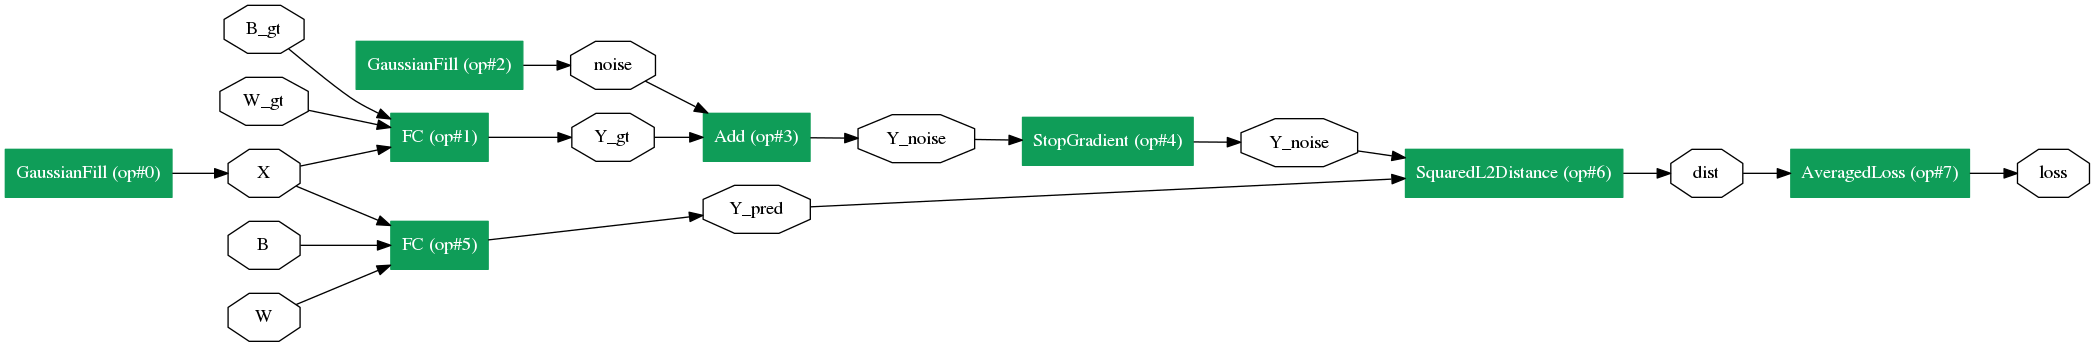

In [51]:
def display_graph():
    graph = net_drawer.GetPydotGraph(train_net.Proto().op, "train", rankdir="LR")
    return display.Image(graph.create_png(), width=800)
display_graph()

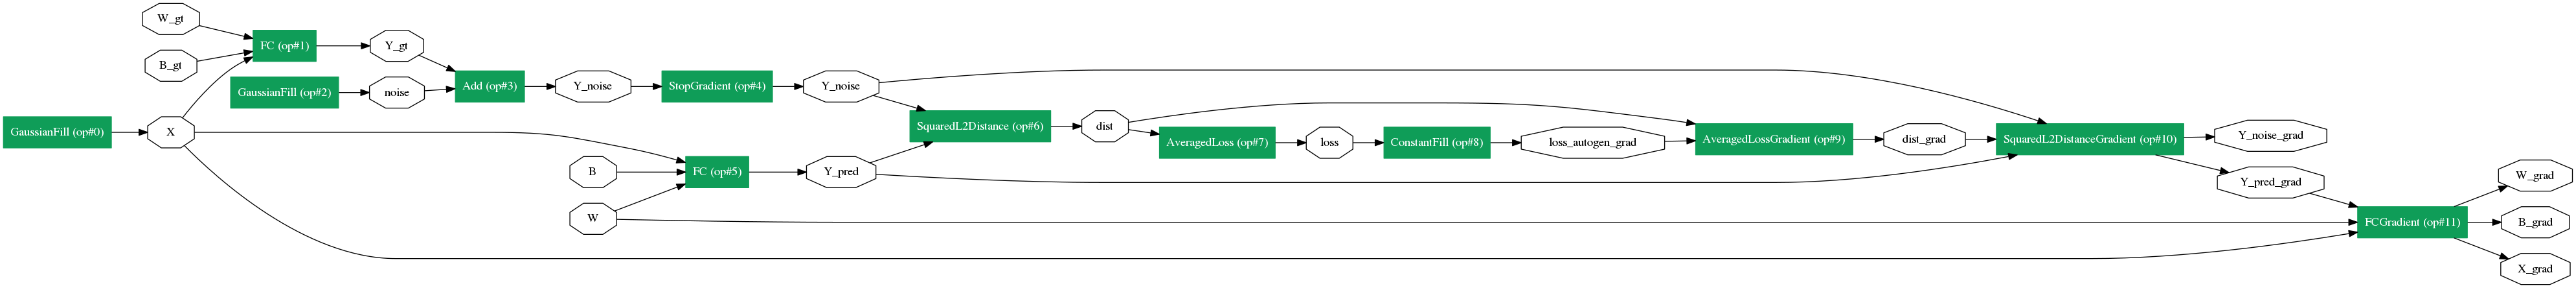

In [52]:
# Get gradients for all the computation above
gradient_map = train_net.AddGradientOperators([loss])
display_graph()

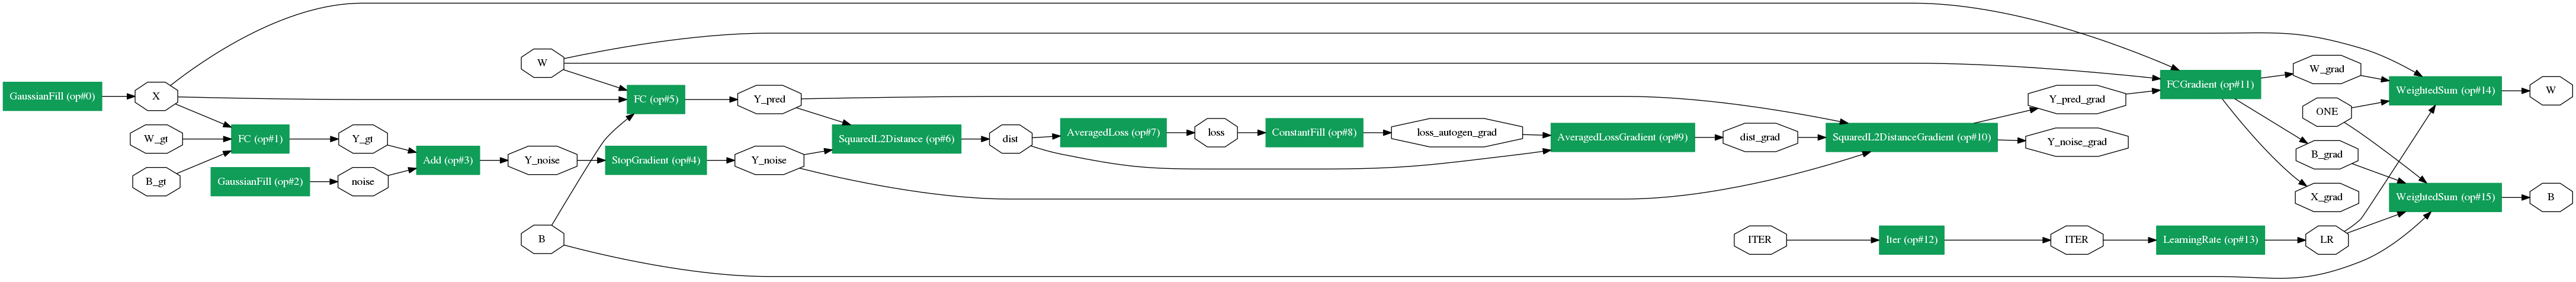

In [53]:
# Increment the iteration by one
train_net.Iter(ITER, ITER)

# Compute the learning rate that corresponds to the iteration
LR = train_net.LearningRate(ITER, "LR", base_lr=0.1, 
                            policy="step", stepsize=20, gamma=0.9)

# Weighted sum
train_net.WeightedSum([W, ONE, gradient_map[W], LR], W)
train_net.WeightedSum([B, ONE, gradient_map[B], LR], B)

# let's show the graph again
display_graph()

In [54]:
# Once network created, run it
workspace.RunNetOnce(init_net)
workspace.CreateNet(train_net)

True

In [55]:
print("Before training, W is: {}".format(workspace.FetchBlob("W")))
print("Before training, B is: {}".format(workspace.FetchBlob("B")))

Before training, W is: [[-0.92726803  0.44180977]]
Before training, B is: [ 0.]


In [56]:
# train
for i in range(100):
    workspace.RunNet(train_net.Proto().name)

In [57]:


print("After training, W is: {}".format(workspace.FetchBlob("W")))
print("After training, B is: {}".format(workspace.FetchBlob("B")))

print("Ground truth W is: {}".format(workspace.FetchBlob("W_gt")))
print("Ground truth B is: {}".format(workspace.FetchBlob("B_gt")))



After training, W is: [[-6240.52539062 -3092.3371582 ]]
After training, B is: [-811.96734619]
Ground truth W is: [[ 2.   1.5]]
Ground truth B is: [ 0.5]


In [64]:
workspace.RunNetOnce(init_net)
w_history = []
b_history = []
for i in range(50):
    workspace.RunNet(train_net.Proto().name)
    w_history.append(workspace.FetchBlob("W"))
    b_history.append(workspace.FetchBlob("B"))
w_history = np.vstack(w_history)
b_history = np.vstack(b_history)
pyplot.plot(w_history[:, 0], w_history[:, 1], 'r')
pyplot.axis('equal')
pyplot.xlabel('w_0')
pyplot.ylabel('w_1')
pyplot.grid(True)
pyplot.figure()
pyplot.plot(b_history)
pyplot.xlabel('iter')
pyplot.ylabel('b')
pyplot.grid(True)